##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Image Classification with Convolutional Neural Networks

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l04c01_image_classification_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l04c01_image_classification_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this tutorial, we'll build and train a neural network to classify images of clothing, like sneakers and shirts.

It's okay if you don't understand everything. This is a fast-paced overview of a complete TensorFlow program, with explanations along the way. The goal is to get the general sense of a TensorFlow project, not to catch every detail.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

## Install and import dependencies

We'll need [TensorFlow Datasets](https://www.tensorflow.org/datasets/), an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with. We're also using a few helper libraries.

In [ ]:
import tensorflow as tf

In [ ]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 $\times$ 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow, using the [Datasets](https://www.tensorflow.org/datasets) API:

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### Explore the processed data

Let's plot an image to see what it looks like.

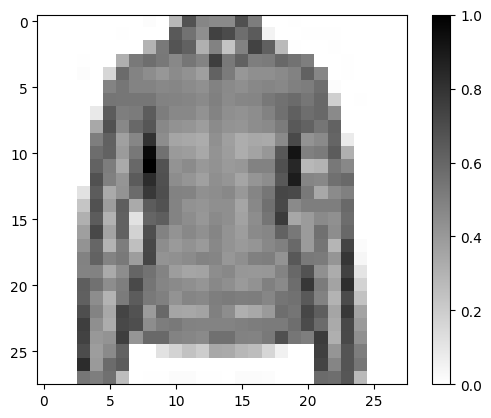

In [ ]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

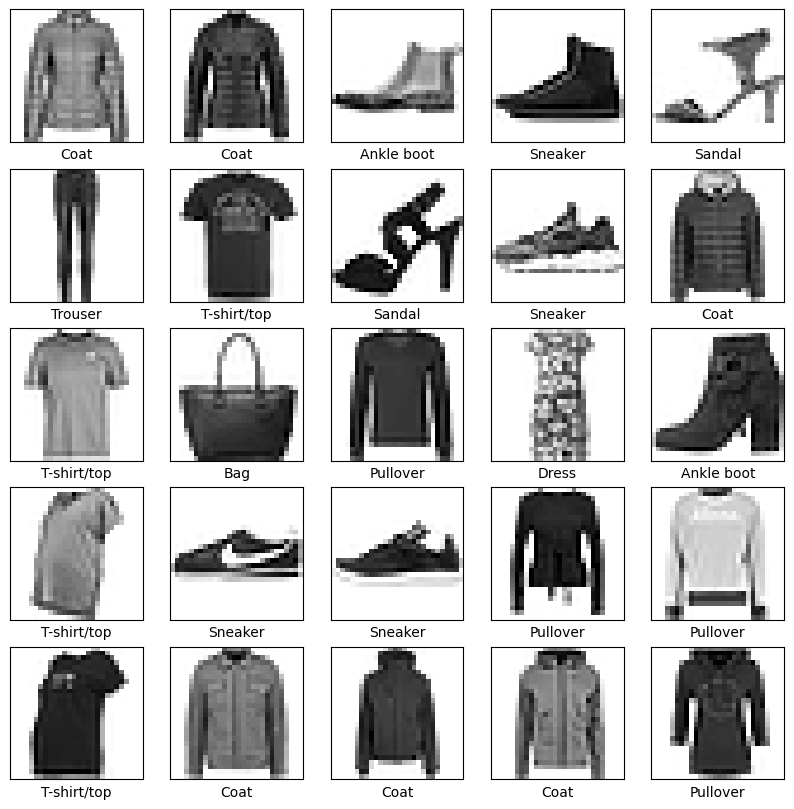

In [ ]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

This network layers are:

* **"convolutions"** `tf.keras.layers.Conv2D and MaxPooling2D`— Network start with two pairs of Conv/MaxPool. The first layer is a Conv2D filters (3,3) being applied to the input image, retaining the original image size by using padding, and creating 32 output (convoluted) images (so this layer creates 32 convoluted images of the same size as input). After that, the 32 outputs are reduced in size using a MaxPooling2D (2,2) with a stride of 2. The next Conv2D also has a (3,3) kernel, takes the 32 images as input and creates 64 outputs which are again reduced in size by a MaxPooling2D layer. So far in the course, we have described what a Convolution does, but we haven't yet covered how you chain multiples of these together. We will get back to this in lesson 4 when we use color images. At this point, it's enough if you understand the kind of operation a convolutional filter performs

* **output** `tf.keras.layers.Dense` — A 128-neuron, followed by 10-node *softmax* layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

> Note: Using `softmax` activation and `SparseCategoricalCrossentropy()` has issues and which are patched by the `tf.keras` model. A safer approach, in general, is to use a linear output (no activation function) with `SparseCategoricalCrossentropy(from_logits=True)`.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

(Don't worry about `steps_per_epoch`, the requirement to have this flag will soon be removed.)

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8059 - loss: 0.5394
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8987 - loss: 0.2720
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9167 - loss: 0.2288
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9294 - loss: 0.1897
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9386 - loss: 0.1692
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9450 - loss: 0.1465
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9543 - loss: 0.1224
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9635 - loss: 0.1003
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9692 - loss: 0.0820
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9711 - loss: 0.0764


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.97 (or 97%) on the training data.

## Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9166 - loss: 0.2992
Accuracy on test dataset: 0.9154999852180481


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. When the model sees images it has never seen during training, (that is, from the `test_dataset`), we can expect performance to go down.

## Make predictions and explore

With the model trained, we can use it to make predictions about some images.

In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


In [ ]:
predictions.shape


(32, 10)

Here, the model has predicted the probability of each label for each image in the testing set. Let's take a look at the first prediction:

In [ ]:
predictions[0]

array([1.42927465e-08, 1.64413913e-10, 9.40469501e-04, 1.48524845e-10,
       9.95456696e-01, 6.27791152e-11, 3.60291614e-03, 9.63857327e-11,
       1.89298813e-10, 1.02403348e-08], dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [ ]:
np.argmax(predictions[0])

np.int64(4)

So the model is usually most confident that this image is a Shirt, or `class_names[6]`. Let's check the label:

In [ ]:
test_labels[0]

np.int64(4)

We can graph this to look at the full set of 10 class predictions

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array.

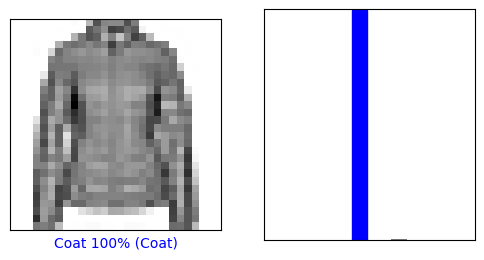

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

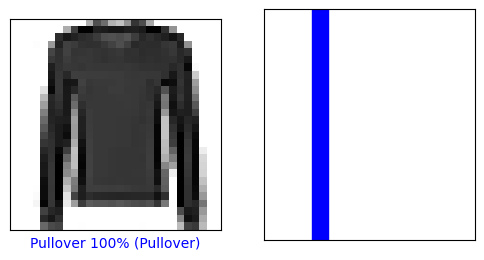

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident.

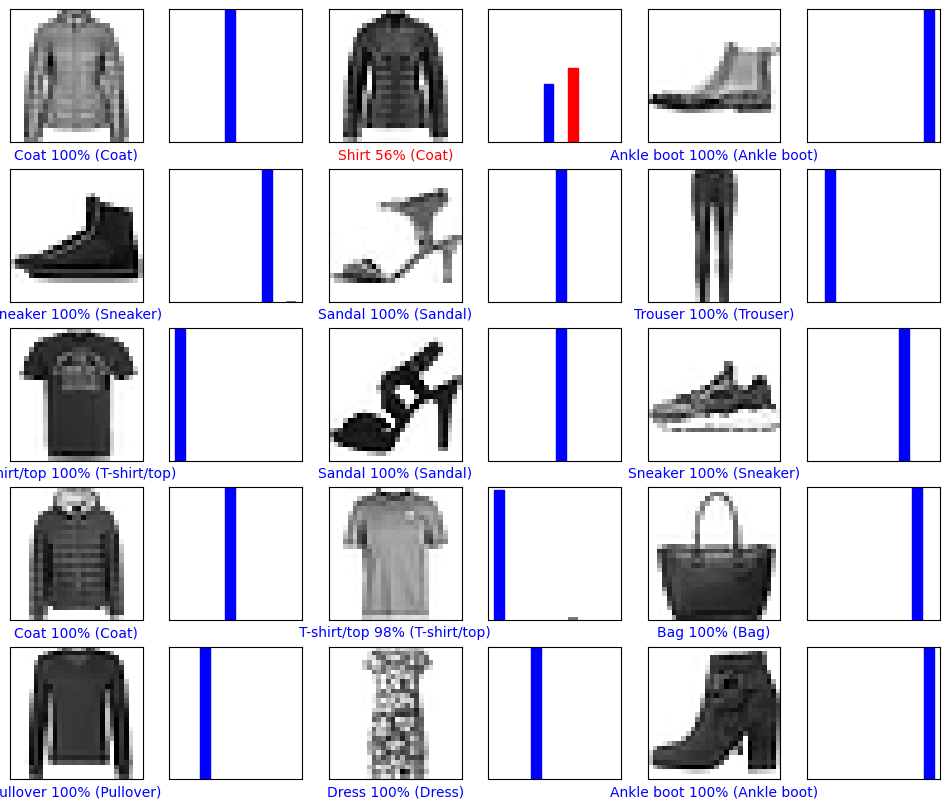

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finally, use the trained model to make a prediction about a single image.

In [ ]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Now predict the image:

In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
[[1.42927465e-08 1.64413913e-10 9.40467697e-04 1.48525414e-10
  9.95456696e-01 6.27791152e-11 3.60291614e-03 9.63859131e-11
  1.89298813e-10 1.02403153e-08]]


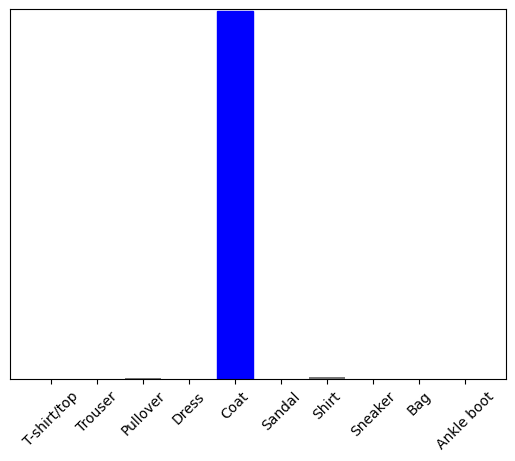

In [ ]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [ ]:
np.argmax(predictions_single[0])

np.int64(4)

And, as before, the model predicts a label of 6 (shirt).

# Exercises

Experiment with different models and see how the accuracy results differ. In particular change the following parameters:
*   Set training epochs set to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes
*   Add additional Dense layers between the Flatten and the final Dense(10), experiment with different units in these layers
*   Don't normalize the pixel values, and see the effect that has


Remember to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).
Also, if you run into trouble, simply reset the entire environment and start from the beginning:
*   Edit -> Clear all outputs
*   Runtime -> Reset all runtimes

## **Epoch = 1**


In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8113 - loss: 0.5331


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8906 - loss: 0.3083
Accuracy on test dataset: 0.8867999911308289


In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


In [ ]:
predictions[13]

array([3.8050421e-02, 3.6219347e-02, 1.0151226e-03, 9.1074491e-01,
       2.5793107e-03, 3.9055553e-04, 8.0206059e-03, 1.1906319e-03,
       1.2149751e-03, 5.7418080e-04], dtype=float32)

In [ ]:
np.argmax(predictions[13])

np.int64(3)

In [ ]:
test_labels[13]

np.int64(3)

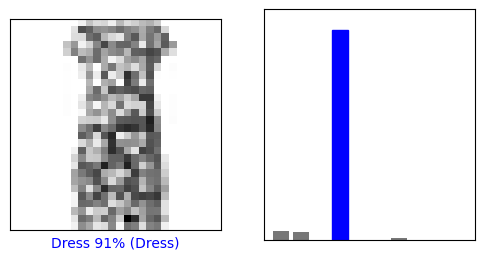

In [ ]:
i = 13
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [ ]:
img = test_images[13]

print(img.shape)

(28, 28, 1)


In [ ]:
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
[[3.8050435e-02 3.6219355e-02 1.0151232e-03 9.1074467e-01 2.5793114e-03
  3.9055565e-04 8.0206124e-03 1.1906322e-03 1.2149754e-03 5.7418121e-04]]


## **Neuron Dense Layers**

### **Lower Dense Layers (Layer = 10)**

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7385 - loss: 0.7425
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8823 - loss: 0.3355
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8991 - loss: 0.2824
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9134 - loss: 0.2480
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9202 - loss: 0.2258
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9289 - loss: 0.2052
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9319 - loss: 0.1903
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9358 - loss: 0.1783
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9422 - loss: 0.1590
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9467 - loss: 0.1471


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9092 - loss: 0.2692
Accuracy on test dataset: 0.9081000089645386


In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


In [ ]:
predictions[13]

array([4.8275292e-03, 2.7269751e-04, 4.1238996e-04, 9.9242264e-01,
       7.3884825e-05, 5.9469613e-07, 1.6892476e-03, 6.7186043e-08,
       1.9945099e-04, 1.0134817e-04], dtype=float32)

In [ ]:
np.argmax(predictions[13])

np.int64(3)

In [ ]:
test_labels[13]

np.int64(3)

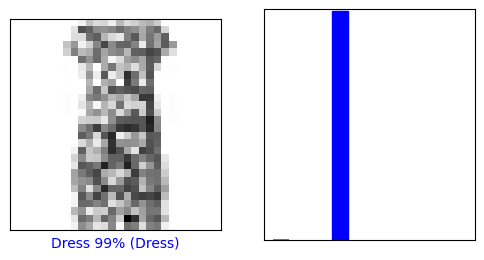

In [ ]:
i = 13
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [ ]:
img = test_images[13]

print(img.shape)

(28, 28, 1)


In [ ]:
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
[[4.82751755e-03 2.72697507e-04 4.12389752e-04 9.92422640e-01
  7.38848248e-05 5.94696132e-07 1.68924662e-03 6.71859155e-08
  1.99450791e-04 1.01347985e-04]]


### **High Dense Layers (Layer = 512)**

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8176 - loss: 1.4352
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8956 - loss: 0.2807
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9114 - loss: 0.2414
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9239 - loss: 0.2028
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9330 - loss: 0.1803
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9394 - loss: 0.1613
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9491 - loss: 0.1424
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9529 - loss: 0.1291
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9601 - loss: 0.1107
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9648 - loss: 0.1010


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9063 - loss: 0.5290
Accuracy on test dataset: 0.9043999910354614


In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


In [ ]:
predictions[13]

array([2.4833476e-14, 1.5798724e-15, 2.6965724e-15, 1.0000000e+00,
       6.1351282e-20, 1.6853858e-17, 8.7432882e-13, 6.2950311e-21,
       6.7174634e-19, 1.7344974e-20], dtype=float32)

In [ ]:
np.argmax(predictions[13])

np.int64(3)

In [ ]:
test_labels[13]

np.int64(3)

In [ ]:
i = 13
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [ ]:
img = test_images[13]

print(img.shape)

(28, 28, 1)


In [ ]:
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
[[2.4833476e-14 1.5798663e-15 2.6965724e-15 1.0000000e+00 6.1351282e-20
  1.6853793e-17 8.7433224e-13 6.2949826e-21 6.7174634e-19 1.7344974e-20]]


## **Add Layers**

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7922 - loss: 0.5721
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8997 - loss: 0.2705
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9163 - loss: 0.2211
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9300 - loss: 0.1884
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9399 - loss: 0.1598
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9498 - loss: 0.1373
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9560 - loss: 0.1198
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9632 - loss: 0.0976
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9682 - loss: 0.0849
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9720 - loss: 0.0775


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9175 - loss: 0.3405
Accuracy on test dataset: 0.9185000061988831


In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


In [ ]:
predictions[13]

array([1.54361624e-06, 1.17929080e-08, 4.07263251e-11, 9.99998331e-01,
       8.53585952e-11, 1.83145979e-13, 1.08519224e-07, 1.92664686e-11,
       2.42069923e-11, 7.71859573e-12], dtype=float32)

In [ ]:
i = 13
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [ ]:
img = test_images[13]

print(img.shape)

(28, 28, 1)


In [ ]:
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
[[1.54361624e-06 1.17929302e-08 4.07263251e-11 9.99998331e-01
  8.53585952e-11 1.83146670e-13 1.08519224e-07 1.92664686e-11
  2.42069923e-11 7.71861047e-12]]


## **Unnormalized**

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8125 - loss: 1.2963
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8979 - loss: 0.2775
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9107 - loss: 0.2412
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9206 - loss: 0.2132
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9290 - loss: 0.1946
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9324 - loss: 0.1803
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9419 - loss: 0.1569
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9461 - loss: 0.1442
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9536 - loss: 0.1289
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9560 - loss: 0.1211


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8999 - loss: 0.4187
Accuracy on test dataset: 0.9028000235557556


In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


In [ ]:
predictions[13]

array([4.4360135e-07, 5.2984113e-08, 5.9321423e-11, 9.9999928e-01,
       7.5548412e-09, 7.7541012e-13, 2.9603646e-07, 4.6098868e-11,
       7.5635748e-10, 6.3030981e-14], dtype=float32)

In [ ]:
i = 13
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [ ]:
img = test_images[13]

print(img.shape)

(28, 28, 1)


In [ ]:
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[[4.4360345e-07 5.2984319e-08 5.9321423e-11 9.9999928e-01 7.5548554e-09
  7.7541012e-13 2.9603731e-07 4.6098781e-11 7.5636036e-10 6.3031225e-14]]


## **1 Convolution Layer**

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8049 - loss: 0.5347
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9011 - loss: 0.2655
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9192 - loss: 0.2162
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9342 - loss: 0.1802
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9417 - loss: 0.1526
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9537 - loss: 0.1258
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9610 - loss: 0.1066
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9672 - loss: 0.0906
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9716 - loss: 0.0766
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9762 - loss: 0.0631


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9017 - loss: 0.3694
Accuracy on test dataset: 0.904699981212616


In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


In [ ]:
predictions[13]

array([6.4629052e-07, 5.9099170e-11, 1.3727041e-09, 9.9999940e-01,
       2.5724395e-10, 4.9365382e-14, 1.7352142e-09, 9.0525655e-15,
       1.8749446e-12, 1.7084839e-14], dtype=float32)

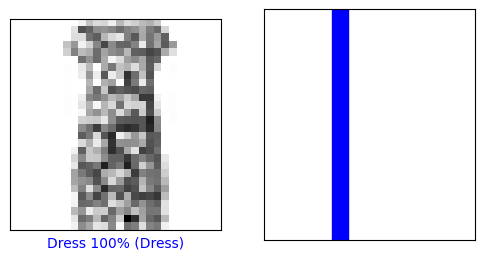

In [ ]:
i = 13
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [ ]:
img = test_images[13]

print(img.shape)

(28, 28, 1)


In [ ]:
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
[[6.4628989e-07 5.9099170e-11 1.3727041e-09 9.9999940e-01 2.5724395e-10
  4.9365571e-14 1.7352142e-09 9.0525655e-15 1.8749446e-12 1.7084839e-14]]


## **3 Convolution Layers**

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7625 - loss: 0.6434
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8931 - loss: 0.2879
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9091 - loss: 0.2432
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9195 - loss: 0.2186
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9278 - loss: 0.1942
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9351 - loss: 0.1743
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9410 - loss: 0.1567
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9472 - loss: 0.1441
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9529 - loss: 0.1269
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9560 - loss: 0.1163


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9180 - loss: 0.2835
Accuracy on test dataset: 0.9203000068664551


In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


In [ ]:
predictions[13]

array([7.8305777e-07, 5.4840070e-09, 5.3898323e-11, 9.9999917e-01,
       4.0776627e-12, 2.8278714e-13, 2.6465225e-08, 7.6768044e-15,
       1.6951979e-10, 2.9882831e-15], dtype=float32)

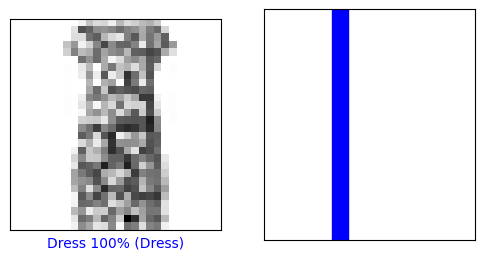

In [ ]:
i = 13
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [ ]:
img = test_images[13]

print(img.shape)

(28, 28, 1)


In [ ]:
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
[[7.8305845e-07 5.4840172e-09 5.3898424e-11 9.9999917e-01 4.0776705e-12
  2.8278714e-13 2.6465225e-08 7.6768044e-15 1.6952043e-10 2.9882945e-15]]
